In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from functorch import make_functional, vmap, grad, jacrev
import functools

from pyDOE import lhs

from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)

device =  cpu


In [3]:
class Plain(nn.Module):
    
    def __init__(self, in_dim , h_dim , out_dim):
        super().__init__()
        self.ln1 = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        self.ln2 = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out
    
def count_parameters(model, requires_grad = True):
    """Count trainable parameters for a nn.Module."""
    if requires_grad:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

In [4]:
def compute_loss_Res(func_params, X_inner, Rf_inner):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    
    grad2_f = (jacrev(grad(f)))(X_inner, func_params)
    dudX2 = (torch.diagonal(grad2_f))
    
    laplace = (dudX2[0] + dudX2[1])
    
    loss_Res = laplace - Rf_inner

    return loss_Res.flatten()


def compute_loss_b(func_params, X_bd, U_bd):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    
    u_pred = f(X_bd, func_params)
    loss_b = u_pred - U_bd
        
    return loss_b.flatten()

def compute_loss_j(func_params, X_ij, Uj_ij):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    
    X_ij=X_ij.reshape(len(X_ij), 1)

    ij_outer = torch.cat((X_ij[0], X_ij[1], 1.0+0.0*X_ij[0]), 0)
    ij_inner = torch.cat((X_ij[0], X_ij[1], -1.0+0.0*X_ij[0]), 0)

    u_ij_outer = f(ij_outer, func_params)
    u_ij_inner = f(ij_inner, func_params)
    
    ij_pred = u_ij_outer - u_ij_inner
    
    loss_j = ij_pred - Uj_ij
        
    return loss_j.flatten()

def compute_loss_normal_jump(func_params, X_ij, Normal_ij, Unj_ij):

    def f(x, func_params):
        output = func_model(func_params, x)
        return output.squeeze(0)
    
    X_ij=X_ij.reshape(len(X_ij), 1)
    
    ij_outer = torch.cat((X_ij[0], X_ij[1], 1.0+0.0*X_ij[0]), 0)
    ij_inner = torch.cat((X_ij[0], X_ij[1], -1.0+0.0*X_ij[0]), 0)

    normal_x = Normal_ij[0]
    normal_y = Normal_ij[1]
    
    grad_f_outer = (grad(f))(ij_outer, func_params)
    df_outer = (grad_f_outer)
    Normal_outer = normal_x*df_outer[0] + normal_y*df_outer[1]
    grad_f_inner = (grad(f))(ij_inner, func_params)
    df_inner = (grad_f_inner)
    Normal_inner = normal_x*df_inner[0] + normal_y*df_inner[1]
    
    normal_jump_pred = 1.0e-3*Normal_outer - Normal_inner

    loss_normal_jump = normal_jump_pred - Unj_ij
        
    return loss_normal_jump.flatten()

In [5]:
# exact_u = exact solution
def exact_u(x, y, z):
    u1 = np.sin(x)*np.sin(y)
    un1 = np.exp(x+y)
    eu = u1*(1.0+z)/2.0 + un1*(1.0-z)/2.0
    return eu

# rhs_f = right hand side function
def rhs_f(x, y, z):
    f1 = -2.0*np.sin(x)*np.sin(y)
    fn1 = 2.0*np.exp(x+y)
    rf = f1*(1.0+z)/2.0 + fn1*(1.0-z)/2.0
    return rf

# normal_u = \nabla u \dot n, normal derivative of u, only defined on the interface
def normal_u(x, y, z):
    normal = normal_vector(x, y)
    normal_x = normal[:, 0:1]
    normal_y = normal[:, 1:2]
    u1x = np.cos(x)*np.sin(y)
    u1y = np.sin(x)*np.cos(y)
    u1 = normal_x*u1x + normal_y*u1y
    un1x = np.exp(x+y)
    un1y = np.exp(x+y)
    un1 = normal_x*un1x + normal_y*un1y
    nu = u1*(1.0+z)/2.0 + un1*(1.0-z)/2.0
    return nu

# normal_vector = normal vector, only defined on the interface
def normal_vector(x, y):
    dist = np.sqrt((25.0*x)**2 + (4.0*y)**2)
    normal_x = 25.0*x/dist
    normal_y = 4.0*y/dist
    normal = np.hstack((normal_x, normal_y))
    return normal

def sign_x(x, y):
    z = 0.0*x + 1.0
    for i in range(len(z)):
        dist = np.sqrt((x[i]/0.2)**2+(y[i]/0.5)**2)
        if dist < 1.0:
            z[i] = -1.0
    return z

In [6]:
# number of grid points
N_inner = 8

# Training points

## X_inner: points inside the domain
X_inner = 2.0*lhs(2, N_inner**2) - 1.0
x = X_inner[:,0:1]
y = X_inner[:,1:2]
z = sign_x(x, y)
Rf_inner = rhs_f(x, y, z)
X_inner = np.hstack((X_inner, z))

## X_bd: points at the boundary, totally 4*N_inner points
xx1 = np.hstack((2.0*lhs(1, N_inner) - 1.0, -1.0*np.ones((N_inner,1))))
xx2 = np.hstack((-1.0*np.ones((N_inner,1)), 2.0*lhs(1, N_inner) - 1.0))
xx3 = np.hstack((np.ones((N_inner,1)), 2.0*lhs(1, N_inner) - 1.0))
xx4 = np.hstack((2.0*lhs(1, N_inner) - 1.0, np.ones((N_inner,1))))
X_bd = np.vstack([xx1, xx2, xx3, xx4])
X_bd = np.hstack((X_bd, 1.0+0.0*X_bd[:,0:1]))

## U_bd: function values on the boundary, totally 4*N_inner points
x = X_bd[:,0:1]
y = X_bd[:,1:2]
z = 0.0*x + 1.0
U_bd = exact_u(x, y, z)

## X_ij: points on the interior interface, totally 4*N_inner points
theta = 2.0*np.pi*lhs(1, 4*N_inner)
x_ij = 0.2*np.cos(theta)
y_ij = 0.5*np.sin(theta)
X_ij = np.hstack([x_ij, y_ij])

## normal vector
Normal_ij = normal_vector(x_ij, y_ij)

## Uj_ij: function jump on the interior interface, totally 4*N_inner points
Uj_ij = exact_u(x_ij, y_ij, 0.0*x_ij+1.0) - exact_u(x_ij, y_ij, 0.0*x_ij-1.0)

# beta_plus
beta_plus = 1.0e-3
## Unj_ij: normal jump on the interior interface, totally 4*N_inner points
Unj_ij = beta_plus*normal_u(x_ij, y_ij, 0.0*x_ij+1.0) - normal_u(x_ij, y_ij, 0.0*x_ij-1.0)

print('Size of inner points: ', X_inner.shape)
print('Size of boundary points: ', X_bd.shape)
print('Size of interface points: ', X_ij.shape)

Size of inner points:  (64, 3)
Size of boundary points:  (32, 3)
Size of interface points:  (32, 2)


In [7]:
X_bd_torch = torch.from_numpy(X_bd).requires_grad_(True).double().to(device)
U_bd_torch = torch.from_numpy(U_bd).double().to(device)
X_inner_torch = torch.from_numpy(X_inner).requires_grad_(True).double().to(device)
Rf_inner_torch = torch.from_numpy(Rf_inner).double().to(device)
X_ij_torch = torch.from_numpy(X_ij).requires_grad_(True).double().to(device)
Normal_ij_torch = torch.from_numpy(Normal_ij).double().to(device)
Uj_ij_torch = torch.from_numpy(Uj_ij).double().to(device)
Unj_ij_torch = torch.from_numpy(Unj_ij).double().to(device)

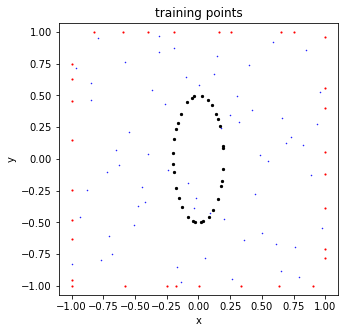

In [8]:
plt.figure(figsize = (5,5))

plt.scatter(X_inner[:,0], X_inner[:,1],
            c = "b", s = 1, marker = ".")
plt.scatter(X_bd[:,0], X_bd[:,1],
            c = "r", s = 5, marker = ".")
plt.scatter(X_ij[:,0], X_ij[:,1],
            c = "k", s = 5, marker = "o")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title('training points')

plt.show()

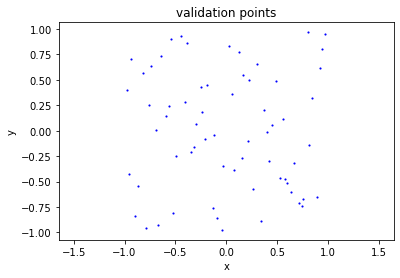

In [9]:
# Validation points

## X_inner: points inside the domain, totally (N_inner)**2 points
X_inner = 2.0*lhs(2, (N_inner)**2) - 1.0
x = X_inner[:,0:1]
y = X_inner[:,1:2]
z = sign_x(x, y)
X_valid_inner = np.hstack((X_inner, z))
Rf_valid_inner = rhs_f(x, y, z)

X_valid_inner_torch = torch.from_numpy(X_valid_inner).requires_grad_(True).double().to(device)
Rf_valid_inner_torch = torch.from_numpy(Rf_valid_inner).double().to(device)

plt.scatter(X_valid_inner[:,0], X_valid_inner[:,1], c = "b", s = 5, marker = ".") 
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title('validation points')

plt.show()

In [10]:
# single-layer model
model = Plain(3, 20, 1).to(device)
print(model)

print(f"Number of paramters: {count_parameters(model)}")

# Make model a functional
func_model, func_params = make_functional(model)

Plain(
  (ln1): Linear(in_features=3, out_features=20, bias=True)
  (act1): Sigmoid()
  (ln2): Linear(in_features=20, out_features=1, bias=False)
)
Number of paramters: 100


In [11]:
LM_iter = 3000
mu_update = 2 # update \mu every mu_update iterations
div_factor = 1.3 # \mu <- \mu/div_factor when loss decreases
mul_factor = 3 # \mu <- mul_factor*\mu when loss incerases

mu = 10**5
loss_sum_old = 10**5
itera = 0

savedloss = []
savedloss_valid = []

In [12]:
%%time
for step in range(LM_iter+1):
    # Put into loss functional to get L_vec
    L_vec_res = vmap(compute_loss_Res, (None, 0, 0))(func_params, X_inner_torch, Rf_inner_torch)
    L_vec_b = vmap(compute_loss_b, (None, 0, 0))(func_params, X_bd_torch, U_bd_torch)
    L_vec_j = vmap(compute_loss_j, (None, 0, 0))(func_params, X_ij_torch, Uj_ij_torch)
    L_vec_nj = vmap(compute_loss_normal_jump, (None, 0, 0, 0))(func_params, X_ij_torch, Normal_ij_torch, Unj_ij_torch)

    L_valid_vec_res = vmap(compute_loss_Res, (None, 0, 0))(func_params, X_valid_inner_torch, Rf_valid_inner_torch)

    L_vec_res = L_vec_res/np.sqrt(N_inner**2)
    L_vec_b = L_vec_b/np.sqrt(4.0*N_inner)
    L_vec_j = L_vec_j/np.sqrt(4.0*N_inner)
    L_vec_nj = L_vec_nj/np.sqrt(4.0*N_inner)
    loss = torch.sum(L_vec_res**2) + torch.sum(L_vec_b**2) + torch.sum(L_vec_j**2) + torch.sum(L_vec_nj**2)
    
    L_valid_vec_res = L_valid_vec_res/np.sqrt(N_inner**2)
    loss_valid = torch.sum(L_valid_vec_res**2)

    # Consturct J for domain points
    # (None, 0 ,0): func_params: no batch. data_d: batch wrt shape[0] (data[i, :]). force_value: batch wrt shape[0] (force_value[i,:])
    
    per_sample_grads = vmap(jacrev(compute_loss_Res), (None, 0, 0))(func_params, X_inner_torch, Rf_inner_torch)
    cnt = 0
    for g in per_sample_grads: 
        g = g.detach()
        J_d_res = g.view(len(g), -1) if cnt == 0 else torch.hstack([J_d_res, g.view(len(g), -1)])
        cnt = 1
    
    per_sample_grads = vmap(jacrev(compute_loss_b), (None, 0, 0))(func_params, X_bd_torch, U_bd_torch)
    cnt = 0
    for g in per_sample_grads: 
        g = g.detach()
        J_d_b = g.view(len(g), -1) if cnt == 0 else torch.hstack([J_d_b, g.view(len(g), -1)])
        cnt = 1
        
    per_sample_grads = vmap(jacrev(compute_loss_j), (None, 0, 0))(func_params, X_ij_torch, Uj_ij_torch)
    cnt = 0
    for g in per_sample_grads: 
        g = g.detach()
        J_d_j = g.view(len(g), -1) if cnt == 0 else torch.hstack([J_d_j, g.view(len(g), -1)])
        cnt = 1
        
    per_sample_grads = vmap(jacrev(compute_loss_normal_jump), (None, 0, 0, 0))(func_params, X_ij_torch, Normal_ij_torch, Unj_ij_torch)
    cnt = 0
    for g in per_sample_grads: 
        g = g.detach()
        J_d_nj = g.contiguous().view(len(g), -1) if cnt == 0 else torch.hstack([J_d_nj, g.view(len(g), -1)])
        cnt = 1

    # cat J_d and J_b into J
    J_mat = torch.cat((J_d_res, J_d_b, J_d_j, J_d_nj))
    L_vec = torch.cat((L_vec_res, L_vec_b, L_vec_j, L_vec_nj))

    # update lambda
    I = torch.eye((J_mat.shape[1])).to(device)

    with torch.no_grad():
        J_product = J_mat.t()@J_mat
        rhs = -J_mat.t()@L_vec
        with torch.no_grad():
            dp = torch.linalg.solve(J_product + mu*I, rhs)

        # update parameters
        cnt=0
        for p in func_params:
            mm=torch.Tensor([p.shape]).tolist()[0]
            num=int(functools.reduce(lambda x,y:x*y,mm,1))
            p+=dp[cnt:cnt+num].reshape(p.shape)
            cnt+=num

        itera += 1
        
        savedloss.append(loss.item())
        savedloss_valid.append(loss_valid.item())

        if step % mu_update == 0:
            #if loss_sum_check < loss_sum_old:
            if loss < loss_sum_old:
                mu = max(mu/div_factor, 10**(-9))
            else:
                mu = min(mul_factor*mu, 10**(8))
            loss_sum_old = loss
                
        if step%500 == 0:
            print(
                    'Iter %d, Loss_Res: %.5e, mu: %.5e' % (itera, loss.item(), mu)
                )            

        if step == LM_iter or loss.item()<10**(-12):
            break

Iter 1, Loss_Res: 3.13871e+00, mu: 7.69231e+04
Iter 501, Loss_Res: 5.72885e-11, mu: 8.91308e-08
Iter 1001, Loss_Res: 2.63369e-11, mu: 6.84369e-08
Iter 1501, Loss_Res: 1.35277e-11, mu: 5.25477e-08
Iter 2001, Loss_Res: 6.94139e-12, mu: 1.03455e-08
Iter 2501, Loss_Res: 3.78904e-12, mu: 7.94356e-09
Iter 3001, Loss_Res: 2.46756e-12, mu: 6.09928e-09
CPU times: user 2min 35s, sys: 9.05 s, total: 2min 44s
Wall time: 42.2 s


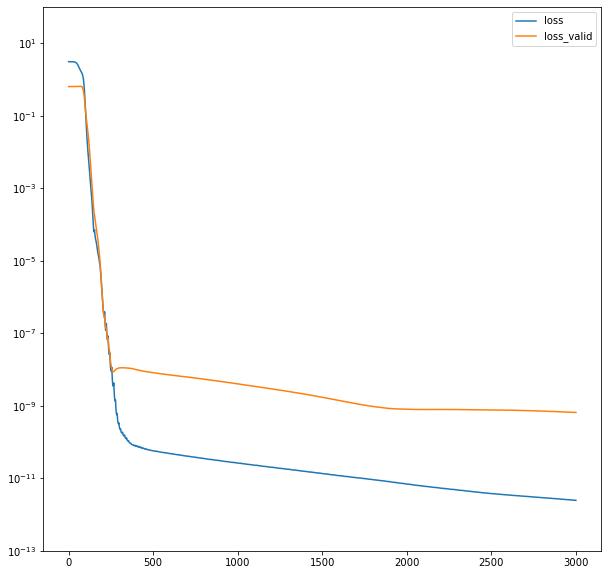

In [13]:
start = 0
end = itera
idx = list(range(start, end, 1))

fig = plt.figure(figsize= (10, 10))
plt.ylim(10**(-13), 10**(2))
plt.yscale("log")
#plt.xscale("log")
plt.plot(idx, savedloss[start:end], label = "loss")
plt.plot(idx, savedloss_valid[start:end], label = "loss_valid")
plt.legend()
plt.show()

In [14]:
# number of test points
N_test = 12800

# Error on the interior points
X_inn = 2.0*lhs(2, N_test) - 1.0
xx = X_inn[:,0:1]
yy = X_inn[:,1:2]
zz = sign_x(xx, yy)
u_test = exact_u(xx, yy, zz)
X_inn = np.hstack((X_inn, zz))
X_inn_torch = torch.tensor(X_inn).double().to(device)
u_pred = func_model(func_params, X_inn_torch).detach().cpu().numpy()

error = np.absolute(u_pred - u_test)

error_u_inf_r = np.linalg.norm(error, np.inf)/np.linalg.norm(u_test, np.inf)
print('Error u (relative inf-norm): %e' % (error_u_inf_r))
error_u_2r = np.linalg.norm(error,2)/np.linalg.norm(u_test,2)
print('Error u (relative 2-norm): %e' % (error_u_2r))
error_u_inf = np.linalg.norm(error, np.inf)
print('Error u (absolute inf-norm): %e' % (error_u_inf))
error_u_2 = np.linalg.norm(error,2)/np.sqrt(N_test)
print('Error u (absolute 2-norm): %e' % (error_u_2))

Error u (relative inf-norm): 1.015134e-06
Error u (relative 2-norm): 4.356070e-07
Error u (absolute inf-norm): 1.732300e-06
Error u (absolute 2-norm): 1.759773e-07


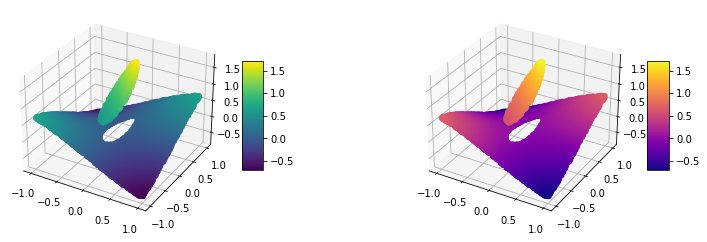

In [15]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.scatter(xx, yy, u_pred, c=u_pred)
fig.colorbar(surf, shrink=0.5, aspect=5)

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.scatter(xx, yy, u_test, c=u_test, cmap='plasma')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

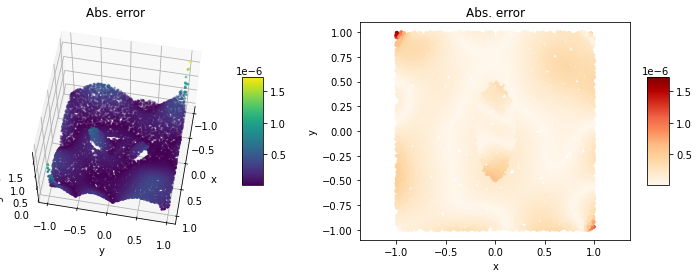

In [16]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.scatter(xx, yy, error, c=error, cmap='viridis', marker = ".", s = 10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=60, azim=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Abs. error')

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2)
surf = ax.scatter(xx, yy, c=error, cmap='OrRd', s = 10)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Abs. error')
ax.axis('equal')
plt.show()